Contents:

1. [California housing dataset using `sklearn`](#california-housing-dataset-using-sklearn)
1. [Multiple linear regression (California housing)](#multiple-linear-regression)
1. [Multicollinearity (Callifornia housing)](#multicollinearity)
1. [Testing out how sklearn performs with high multicollinearity using artificial data](#experiment-time)
1. [Experimenting with `StandardScaler`](#testing-the-scaler)
1. [Ridge regression using `sklearn`](#ridge-regression)
1. [Ridge regression following video tutorial](#ridge-following-tutorial-video)
1. [Lasso](#lasso)

In [2]:
# import modules

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn.linear_model as skl_lm

#### California housing dataset using `sklearn`

In [3]:
# read in California housing dataset
from sklearn.datasets import fetch_california_housing
housing=fetch_california_housing()

In [4]:
from sklearn.model_selection import train_test_split

# create dataframe for feature and target
X=pd.DataFrame(housing.data, columns=housing.feature_names)[["AveRooms"]]
y=housing.target # Median house value in $100,000s

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)
# we set random_state=42 kinda like setting a seed, so that the results are reproducible
# otherwise, everytime we run the code we would get a different result
# test_size=0.2 means that 0.2 of the data is for testing, 0.8 is for training

In [5]:
X.head()

,AveRooms
0,6.984127
1,6.238137
2,8.288136
3,5.817352
4,6.281853


In [6]:
from sklearn.preprocessing import StandardScaler
# (this is a data preprocessing tool to remove the mean 
# and scale features to unit variance to prevent certain
# features from dominating the model due to differences in scale)

# instantiate StandardScaler
scaler=StandardScaler()

# Fit and transform training data and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

The scaler is fitted on the training data using the `fit_transform()` method. The test data is then transformed separately using the `transform()` method to ensure it is scaled using the same factors as the training data, preventing data leakage.

In [7]:
from sklearn.linear_model import LinearRegression

# instantiate linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [8]:
# Make predictions on the testing data
y_pred = model.predict(X_test_scaled)

In [9]:
# Import metrics
from sklearn.metrics import mean_squared_error, r2_score

# Calculate and print R^2 score
r2=r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

R-squared: 0.0138


In [10]:
# Calculate and print MSE
mse=mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.4f}")

Mean squared error: 1.2923


In [11]:
# Calculate and print RMSE
rmse = mse ** 0.5
print(f"Root mean squared error: {rmse:.4f}")

Root mean squared error: 1.1368


### Multiple Linear Regression

Now instead of regressing median house value onto just AveRooms, we try using all of the available features instead in a multiple regression model.

In [12]:
X2=pd.DataFrame(housing.data, columns=housing.feature_names)
y=housing.target
X2_train, X2_test, y_train, y_test=train_test_split(X2,y,test_size=0.2, random_state=42)

# Scale the data
scaler=StandardScaler()

X2_train_scaled=scaler.fit_transform(X2_train)
X2_test_scaled=scaler.transform(X2_test)

# Create model and fit it to the training data
model2=LinearRegression()
model2.fit(X2_train_scaled, y_train)

# Make predictions
y_pred=model2.predict(X2_test_scaled)

# Calculate and print errors
r2 = r2_score(y_test, y_pred)
print(f"R squared:{r2:.4f}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error:{mse:.4f}")

rmse = mse**0.5
print(f"Root mean squared error:{rmse:.4f}")


R squared:0.5758
Mean squared error:0.5559
Root mean squared error:0.7456


### Multicollinearity

In [13]:
# Compute correlation matrix
corr_matrix = X2.corr()
corr_matrix

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000


In [14]:
print(corr_matrix.iloc[1,2]) # quick revision
print(corr_matrix.loc['HouseAge','AveRooms'])
print(X2.columns)

-0.15327742256198923
-0.15327742256198923
Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')


On the diagonals we have the correlation of each feature with themselves which makes sense to be 1. We see that the average number of bedrooms seems to be very positively correlated with the average number of rooms, which makes sense. 

Identifying highly correlated pairs may not be something we want to do manually when the number of features is large. So

In [15]:
high_corr_features = [(col1, col2, corr_matrix.loc[col1,col2])
                      for col1 in corr_matrix.columns
                      for col2 in corr_matrix.columns
                      if col1!=col2 and abs(corr_matrix.loc[col1,col2])>0.8
                      ]

collinearity_df=pd.DataFrame(high_corr_features, columns=["Feature1", "Feature2", "Correlation"])
print("\nHighly Correlated Features:\n",collinearity_df)


Highly Correlated Features:
     Feature1   Feature2  Correlation
0   AveRooms  AveBedrms     0.847621
1  AveBedrms   AveRooms     0.847621
2   Latitude  Longitude    -0.924664
3  Longitude   Latitude    -0.924664


In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Compute VIF
vif_data=pd.DataFrame()
vif_data["Feature"]=X2.columns
vif_data["VIF"]=[variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]

# Print VIF
print("\nVariance Inflation Factor (VIF) for each feature:\n", vif_data)


Variance Inflation Factor (VIF) for each feature:
       Feature         VIF
0      MedInc   11.511140
1    HouseAge    7.195917
2    AveRooms   45.993601
3   AveBedrms   43.590314
4  Population    2.935745
5    AveOccup    1.095243
6    Latitude  559.874071
7   Longitude  633.711654


Let's see what happens if we remove `AveBedrms` from the model


In [17]:
X3=X2.drop(columns=["AveBedrms"])

X3_train, X3_test, y_train, y_test=train_test_split(X3,y,train_size=0.8,random_state=42)

# scale data
X3_train_scaled=scaler.fit_transform(X3_train)
X3_test_scaled=scaler.transform(X3_test)

# Create a linear regression model and train it
model3=LinearRegression()
model3.fit(X3_train_scaled,y_train)

# Make predictions
y_pred=model3.predict(X3_test_scaled)

# Calculate performance metrics
R2=r2_score(y_test,y_pred)

In [18]:
X3_train_scaled

array([[-0.326196  ,  0.34849025, -0.17491646, ...,  0.05137609,
        -1.3728112 ,  1.27258656],
       [-0.03584338,  1.61811813, -0.40283542, ..., -0.11736222,
        -0.87669601,  0.70916212],
       [ 0.14470145, -1.95271028,  0.08821601, ..., -0.03227969,
        -0.46014647, -0.44760309],
       ...,
       [-0.49697313,  0.58654547, -0.60675918, ...,  0.02030568,
        -0.75500738,  0.59946887],
       [ 0.96545045, -1.07984112,  0.40217517, ...,  0.00707608,
         0.90651045, -1.18553953],
       [-0.68544764,  1.85617335, -0.85144571, ..., -0.08535429,
         0.99543676, -1.41489815]])

### Experiment time

In [78]:
import pandas as pd
import numpy as np

# Define the number of rows and columns
num_rows = 100
num_cols = 4

# Define column names (optional, but good practice)
column_names = [f'col_{i+1}' for i in range(num_cols)]

# Generate random data using NumPy
# For random integers: np.random.randint(low, high, size=(rows, cols))
# For random floats: np.random.rand(rows, cols) or np.random.uniform(low, high, size=(rows, cols))
random_data = np.random.randint(0, 100, size=(num_rows, num_cols)) # Example: random integers between 0 and 99

# Create the DataFrame
df = pd.DataFrame(random_data, columns=column_names)

for i in range(num_rows):
    df.iloc[i,1]=2*df.iloc[i,0]
    df.iloc[i,num_cols-1]=df.iloc[i,0]+2*df.iloc[i,1]+3*df.iloc[i,2]+np.random.randint(-10,10)

# Print the generated DataFrame
print(df)

    col_1  col_2  col_3  col_4
0      36     72     29    266
1      17     34     86    339
2      28     56     78    379
3      32     64     30    251
4      59    118     44    432
..    ...    ...    ...    ...
95     42     84     49    357
96     34     68     83    410
97     50    100     74    474
98     95    190     79    720
99     24     48      9    148

[100 rows x 4 columns]


In [80]:
X=df.drop(columns=['col_4'])
y=df['col_4']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=42)

# standardise
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

# build model
model=LinearRegression()
model.fit(X_train_scaled,y_train)


LinearRegression()

In [81]:
print(X_train_scaled.shape)

(80, 3)


In [82]:
print(model.coef_, model.intercept_)

[68.57881784 68.57881784 84.04068989] 407.4875


In [98]:
b1=(model.coef_[1]+model.coef_[0])/3
b3=b1*3

b3

137.1576356864348

In [85]:
pinv_arr=np.ones((80,4))
for i in range(X_train_scaled.shape[0]):
    for j in range(4):
        if j<3:
            pinv_arr[i,j]=X_train_scaled[i,j]

pinv=np.linalg.pinv(pinv_arr)
print(np.matmul(pinv,y_train))

[ 68.57881784  68.57881784  84.04068989 407.4875    ]


In [97]:
# model fit to unscaled data

model_unscaled=LinearRegression()
model_unscaled.fit(X_train,y_train)
print(model_unscaled.coef_, model_unscaled.intercept_)

# real relationship: Y=X_1+2X_2+3X_3

[1.00307402 2.00614804 2.96859338] 0.9996705180641356


In [96]:
# using pseudoinverse for unscaled data matrix

# add one column of ones for constant term
pinv_arr=np.ones((80,4))
for i in range(80):
    for j in range(4):
        if j<3:
            pinv_arr[i,j]=X_train.iloc[i,j]

pinv2=np.linalg.pinv(pinv_arr)
print(np.matmul(pinv2,y_train))

[1.00307402 2.00614804 2.96859338 0.99967052]


In [71]:
X_train.head

<bound method NDFrame.head of     col_1  col_2  col_3
55      2      4     72
88     93    186      3
26     54    108     27
42     32     64      8
69     19     38     45
..    ...    ...    ...
60     93    186     30
71     10     20     42
14     99    198     89
92     62    124     55
51     57    114     91

[80 rows x 3 columns]>

In [70]:
X_train_scaled

array([[-1.63048810e+00, -1.63048810e+00,  7.73215892e-01],
       [ 1.50805060e+00,  1.50805060e+00, -1.88938656e+00],
       [ 1.62962586e-01,  1.62962586e-01, -9.63263965e-01],
       [-5.95805011e-01, -5.95805011e-01, -1.69644435e+00],
       [-1.04416768e+00, -1.04416768e+00, -2.68672022e-01],
       [ 1.09417736e+00,  1.09417736e+00,  1.19768875e+00],
       [ 1.62962586e-01,  1.62962586e-01, -6.54556435e-01],
       [-8.37231064e-01, -8.37231064e-01,  1.00474654e+00],
       [ 3.00920331e-01,  3.00920331e-01,  7.34627451e-01],
       [-1.66497753e+00, -1.66497753e+00,  3.48743038e-01],
       [-1.63048810e+00, -1.63048810e+00, -1.04044085e+00],
       [-1.28559373e+00, -1.28559373e+00, -1.69644435e+00],
       [ 9.39837137e-02,  9.39837137e-02, -6.15967994e-01],
       [ 9.56219619e-01,  9.56219619e-01, -1.54209058e+00],
       [ 1.16315624e+00,  1.16315624e+00, -8.86087083e-01],
       [ 1.19764567e+00,  1.19764567e+00,  1.00474654e+00],
       [ 3.35409767e-01,  3.35409767e-01

### Testing the scaler

In [113]:
# Define the number of rows and columns
num_rows = 100
num_cols = 4

# Define column names (optional, but good practice)
column_names = [f'col_{i+1}' for i in range(num_cols)]

# Generate random data using NumPy
# For random integers: np.random.randint(low, high, size=(rows, cols))
# For random floats: np.random.rand(rows, cols) or np.random.uniform(low, high, size=(rows, cols))
random_data = np.random.randint(0, 100, size=(num_rows, num_cols)) # Example: random integers between 0 and 99

# Create the DataFrame
df = pd.DataFrame(random_data, columns=column_names)

for i in range(num_rows):
    df.iloc[i,num_cols-1]=df.iloc[i,0]+2*df.iloc[i,1]+3*df.iloc[i,2]+np.random.randint(-10,10)

# Print the generated DataFrame
print(df)

    col_1  col_2  col_3  col_4
0      81     19     25    197
1       2     28     23    117
2      28      4     42    156
3      91      8     47    251
4      32     66     47    295
..    ...    ...    ...    ...
95     86     14     13    151
96     55     26     47    244
97     70     70     55    380
98     36     74     39    306
99     45     48     78    376

[100 rows x 4 columns]


In [115]:
X=df.drop(columns=['col_4'])
y=df['col_4']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=42)

# standardise
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

# build model
model=LinearRegression()
model_scaled=model.fit(X_train_scaled,y_train)
model_unscaled=model.fit(X_train,y_train)


In [116]:
print("Scaled: ",model_scaled.coef_, model_scaled.intercept_)
print("Unscaled: ",model_unscaled.coef_, model_unscaled.intercept_)

Scaled:  [0.9964221  1.98617482 2.99865205] 0.1039102815032038
Unscaled:  [0.9964221  1.98617482 2.99865205] 0.1039102815032038


### Ridge regression

In [25]:
# importing modules
from sklearn.linear_model import RidgeCV

data=fetch_california_housing()
X=data.data
y=data.target

X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.8, random_state=42)

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

ridge_cv=RidgeCV(alphas=[0.1,1.0,10.0],cv=5) #alpha = regularisation parameter
ridge_cv.fit(X_train_scaled, y_train)

# make predictions
y_pred=ridge_cv.predict(X_test_scaled)
print("Model score (R^2): ", r2_score(y_test,y_pred))


Model score (R^2):  0.5757905180002316


# Ridge (following tutorial video)

Mastering Ridge Regression in Python with scikit-learn

https://www.youtube.com/watch?v=GMF4Td7KtB0

In [26]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [27]:
X,y=make_regression(n_samples=100, n_features=4, noise=1, random_state=42, effective_rank=2)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=19)

In [29]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)


In [30]:
ridge=Ridge()
ridge.fit(X_train_scaled, y_train)


Ridge()

In [31]:
y_pred=ridge.predict(X_test_scaled)
r2_score(y_test,y_pred)

0.9910426143352267

In [32]:
param_grid={
    'alpha':[0.0001,0.001,0.01,0.1,1.0,10.0,100.0]
}

ridge_cv=GridSearchCV(ridge, param_grid, cv=3, n_jobs=-1)
ridge_cv.fit(X_train_scaled,y_train)


GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})

In [33]:
y_pred2=ridge_cv.predict(X_test_scaled)
r2_score(y_test,y_pred2)

0.9917744487658325

In [34]:
ridge_cv.best_estimator_

Ridge(alpha=0.0001)

In [35]:
print(ridge_cv.best_estimator_.intercept_, ridge_cv.best_estimator_.coef_)

0.1512162580040324 [4.3844567  5.0806461  7.6664195  2.89485579]


### Lasso 

https://www.datacamp.com/tutorial/tutorial-lasso-ridge-regression

In [102]:
#libraries
import seaborn as sns # for heatmap
from sklearn.linear_model import Ridge, RidgeCV, Lasso

#data
cali=fetch_california_housing()
cali_df=pd.DataFrame(cali.data,columns=cali.feature_names)

#target variable
cali_df['Price']=cali.target

#preview
cali_df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


<Axes: >

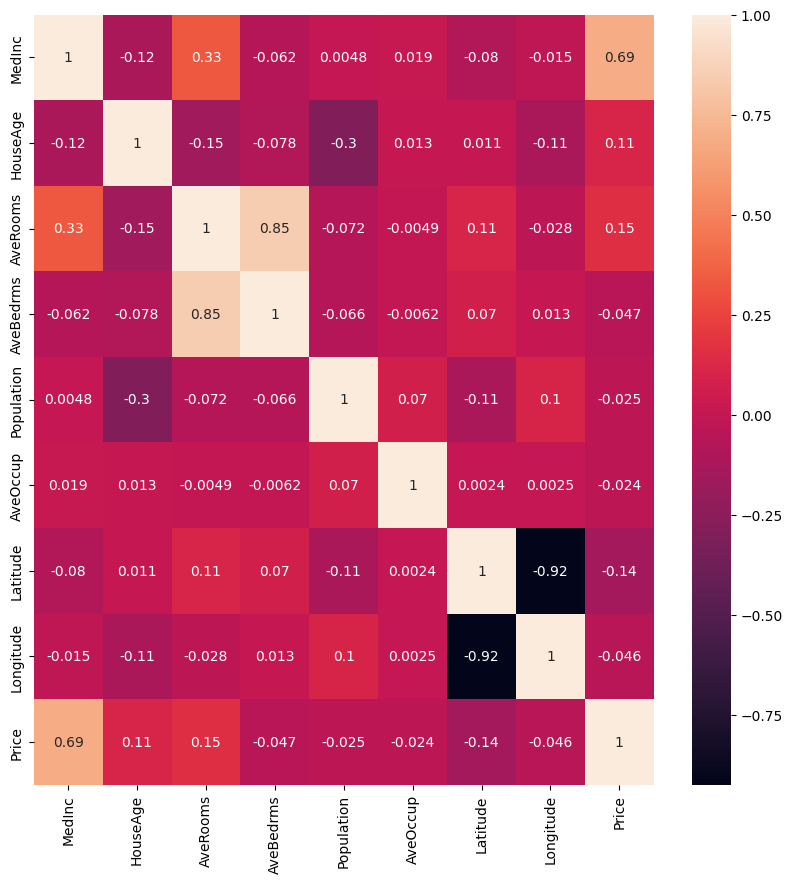

In [103]:
#Exploration
plt.figure(figsize = (10, 10))
sns.heatmap(cali_df.corr(), annot = True)

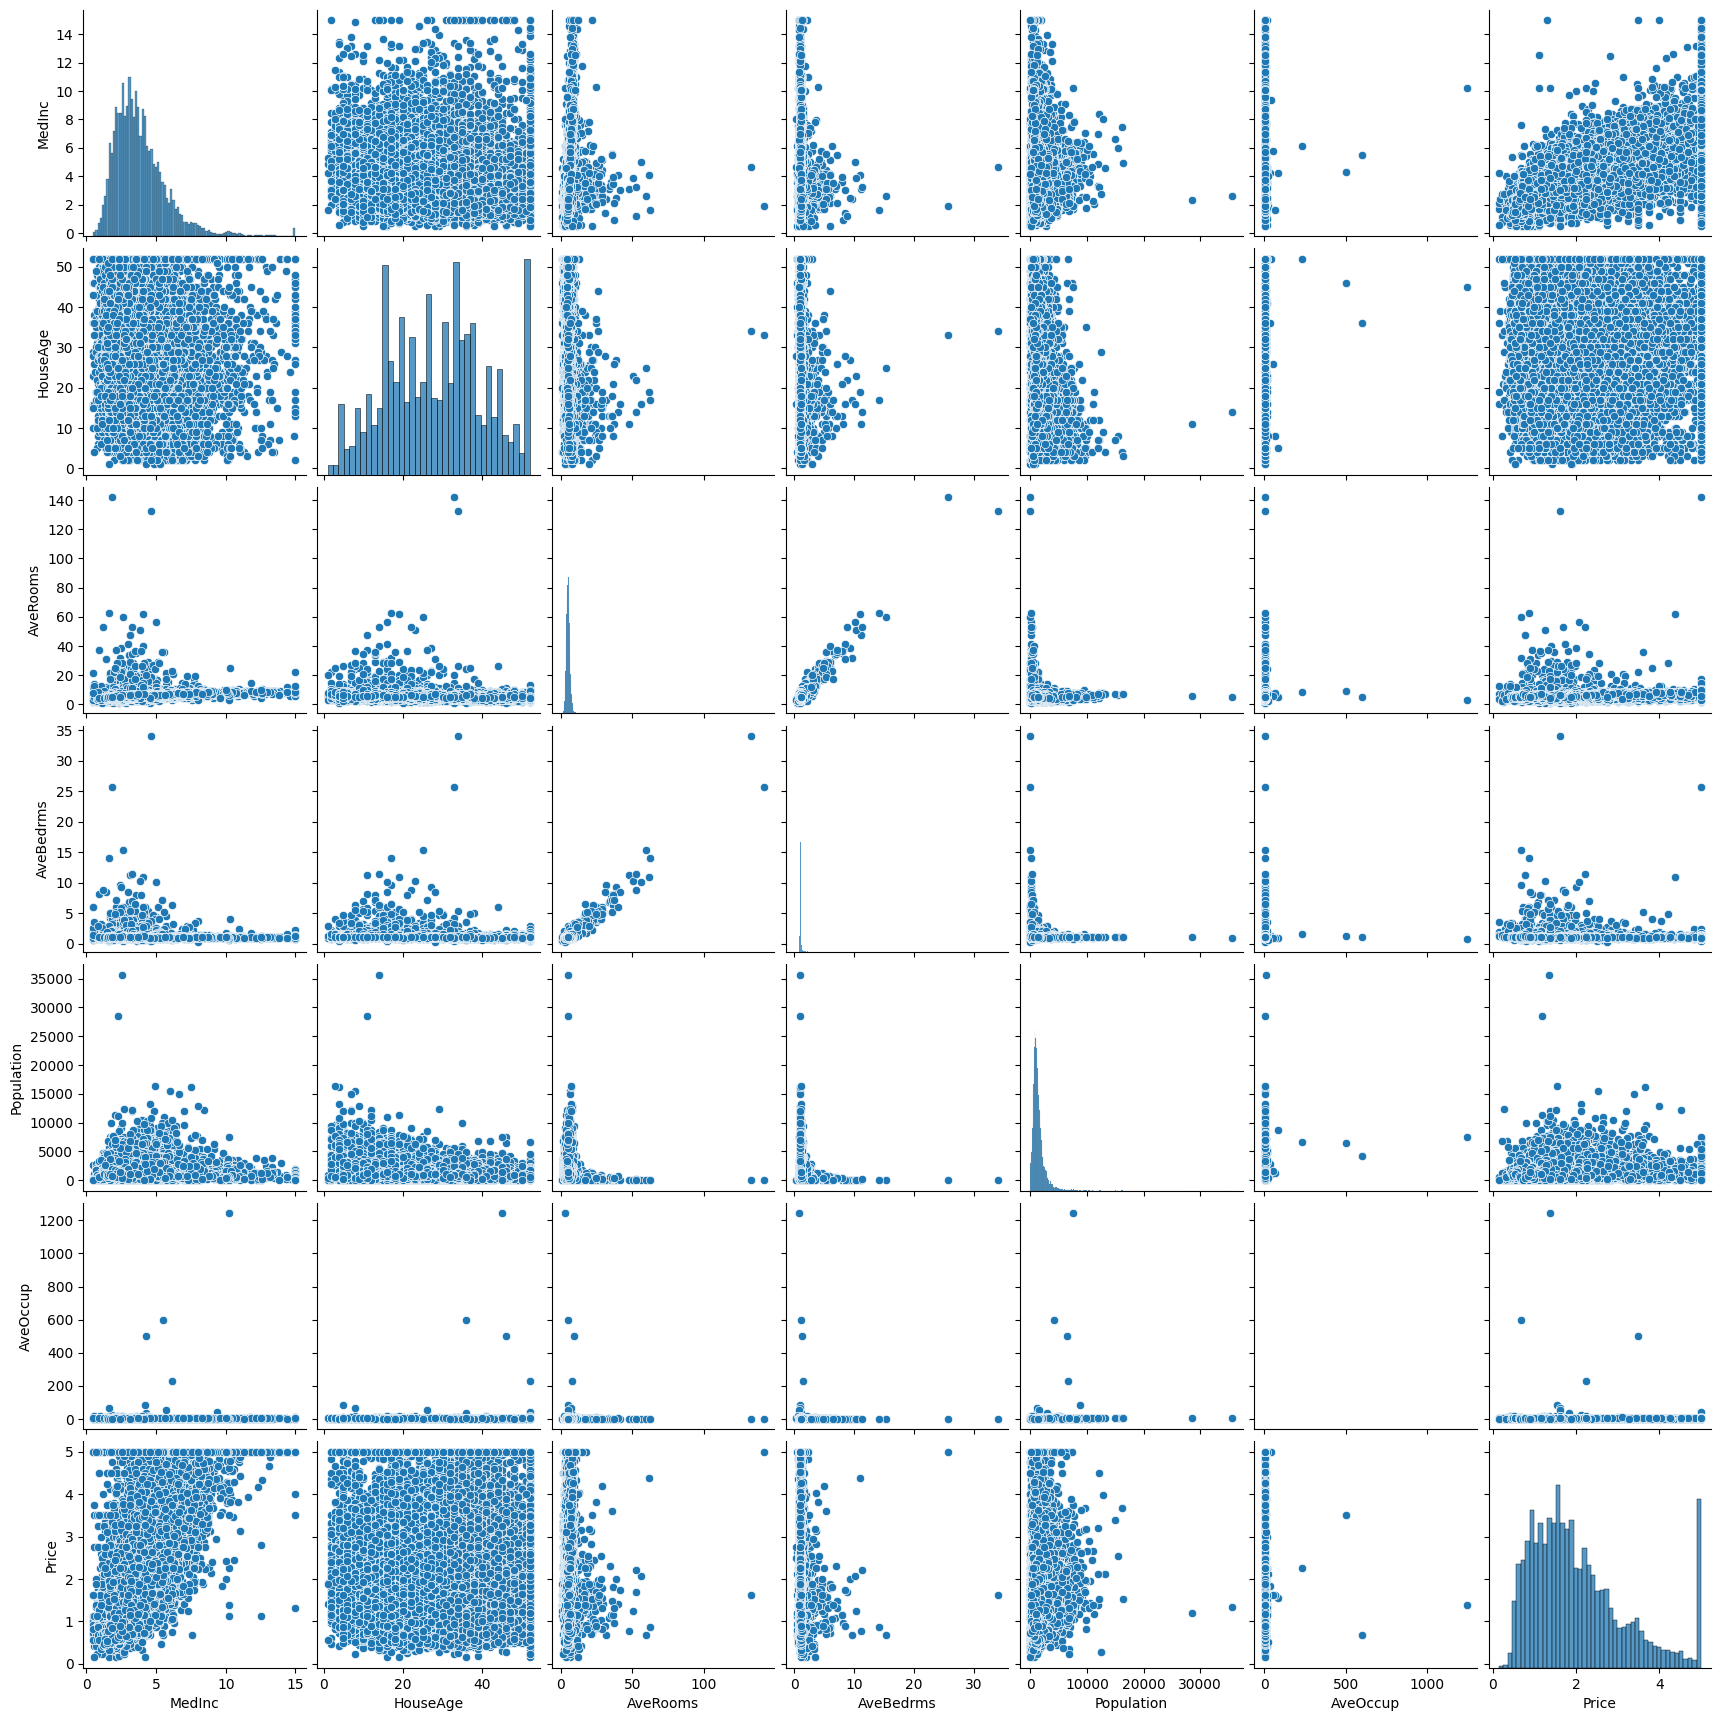

In [104]:
#There are cases of multicolinearity, we will drop a few columns
cali_df.drop(columns = ["Latitude", "Longitude"], inplace = True)

#pairplot
sns.pairplot(cali_df)


In [105]:
#preview
features = cali_df.columns[0:6]
target = cali_df.columns[-1]

#X and y values
X = cali_df[features].values
y = cali_df[target].values

#splot
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

print("The dimension of X_train is {}".format(X_train.shape))
print("The dimension of X_test is {}".format(X_test.shape))
#Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


The dimension of X_train is (16512, 6)
The dimension of X_test is (4128, 6)


In [106]:
features

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup'],
      dtype='object')

In [107]:
#Model
lr = LinearRegression()

#Fit model
lr.fit(X_train, y_train)

#predict
#prediction = lr.predict(X_test)

#actual
actual = y_test

train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)

print("The train score for lr model is {}".format(train_score_lr))
print("The test score for lr model is {}".format(test_score_lr))


#Ridge Regression Model
ridgeReg = Ridge(alpha=10)

ridgeReg.fit(X_train,y_train)

#train and test scorefor ridge regression
train_score_ridge = ridgeReg.score(X_train, y_train)
test_score_ridge = ridgeReg.score(X_test, y_test)

print("\nRidge Model............................................\n")
print("The train score for ridge model is {}".format(train_score_ridge))
print("The test score for ridge model is {}".format(test_score_ridge))


The train score for lr model is 0.5396618408923413
The test score for lr model is 0.5391079183756285

Ridge Model............................................

The train score for ridge model is 0.5396579595225766
The test score for ridge model is 0.53901641557117


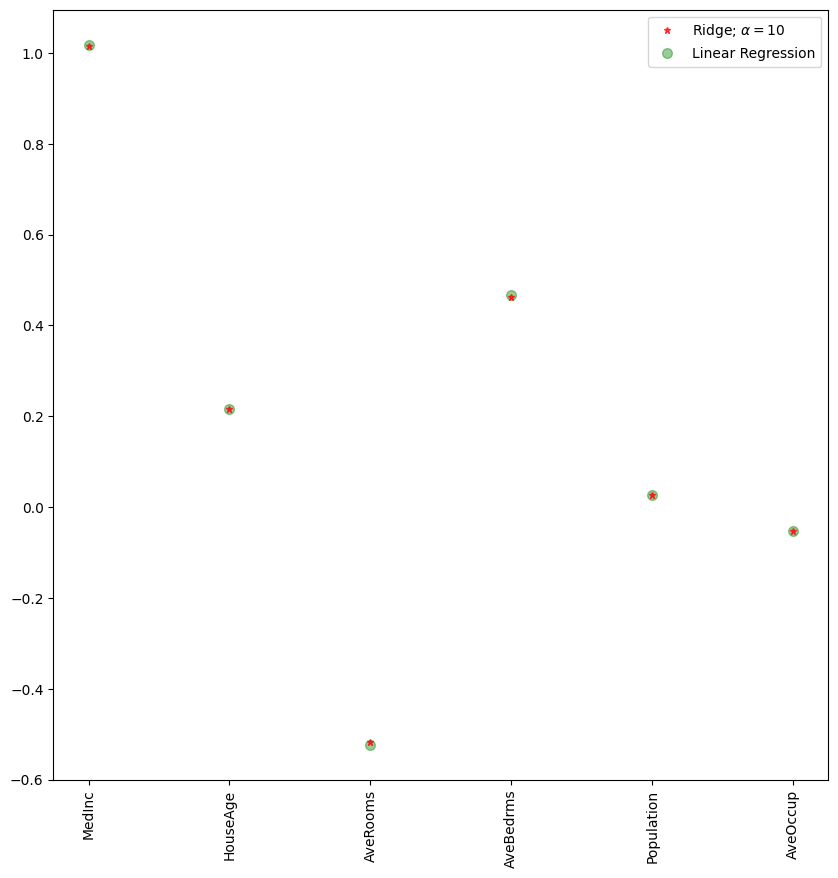

In [108]:
plt.figure(figsize = (10, 10))
plt.plot(features,ridgeReg.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 10$',zorder=7)
#plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$')
plt.plot(features,lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
plt.xticks(rotation = 90)
plt.legend()
plt.show()


In [109]:
#Lasso regression model
print("\nLasso Model............................................\n")
lasso = Lasso(alpha = 10)
lasso.fit(X_train,y_train)
train_score_ls =lasso.score(X_train,y_train)
test_score_ls =lasso.score(X_test,y_test)

print("The train score for ls model is {}".format(train_score_ls))
print("The test score for ls model is {}".format(test_score_ls))



Lasso Model............................................

The train score for ls model is 0.0
The test score for ls model is -0.00022671265337370627


<Axes: >

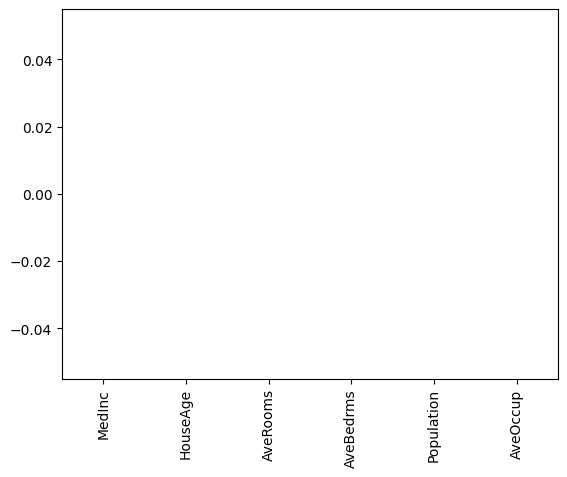

In [110]:
pd.Series(lasso.coef_, features).sort_values(ascending = True).plot(kind = "bar")


Selecting optimal alpha values using cross-validation

In [111]:
#Using the linear CV model
from sklearn.linear_model import LassoCV

#Lasso Cross validation
lasso_cv = LassoCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10], random_state=0).fit(X_train, y_train)


#score
print(lasso_cv.score(X_train, y_train))
print(lasso_cv.score(X_test, y_test))


0.5364043020500886
0.5337673351748846


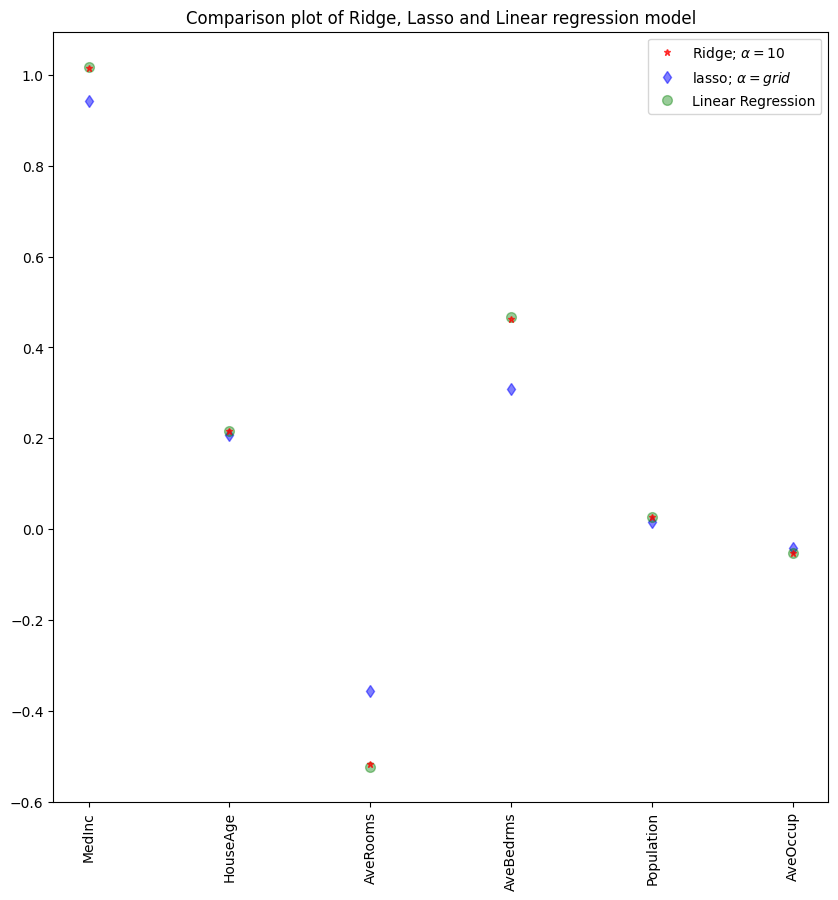

In [112]:
#plot size
plt.figure(figsize = (10, 10))
#add plot for ridge regression
plt.plot(features,ridgeReg.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 10$',zorder=7)

#add plot for lasso regression
plt.plot(lasso_cv.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'lasso; $\alpha = grid$')

#add plot for linear model
plt.plot(features,lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Ridge, Lasso and Linear regression model")
plt.show()
